# Virginia Redistricting Plan

Steps to generate an ensemble of districting plans:

* [Step 1](#step1): Setting up the initial districting plan
    * Load the `.shp` file into a graph object
    * Setting up updaters
    * Instantiating the partition
* [Step 2](#step2): Comuting metrics
    * Partition districts
    * Compactness scores
    * Votes & Wasted Votes
    * Efficiency gap
    * Mean median
    * Partisan bias
    * Partisan gini

    
Resource:

* [Virginia Election Shapefile](https://github.com/mggg-states/VA-shapefiles)
* [Getting started with GerryChain](https://gerrychain.readthedocs.io/en/latest/user/quickstart.html)

## Step 0: Imports

In [1]:
from gerrychain import (GeographicPartition, 
                        Partition, 
                        Graph, 
                        MarkovChain,
                        proposals, 
                        updaters, 
                        constraints, 
                        accept, 
                        Election)
from gerrychain.constraints import (single_flip_contiguous, 
                                    no_more_discontiguous,
                                    Validator)
from gerrychain.updaters import Tally, cut_edges
from gerrychain.proposals import propose_random_flip, recom
from gerrychain.accept import always_accept

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from functools import partial

import networkx as nx
import maup
import geopandas

import gerrychain
import gerrychain.metrics as gm
import gerrychain.metrics.partisan as pm

In [2]:
pd.options.display.max_columns = None
%matplotlib inline

<a id='step1'></a>
## Step 1: Setting up the initial districting plan

### Generating a graph to be partitioned

In [3]:
# Loading the .shp file into a graph
graph = Graph.from_file("va.shp")

C:\Users\HONGW\anaconda3\envs\gerrychain\lib\site-packages\gerrychain\graph\adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(887, 892), (893, 915), (892, 914), (887, 893)}
  warnings.warn(


### Setting up election data

In [4]:
# Configure Election objects representing 
# some of the election data from shapefile
elections = [
    # Number of votes for 2016 presidential candidate
    Election("PRES16", {"Democratic": "G16DPRS", 
                        "Republican": "G16RPRS"})
]
elections_rd = [
    # Number of votes for 2016 presidential candidate
    Election("PRES16", {"Republican": "G16RPRS",
                        "Democratic": "G16DPRS"})
]

### Configuring our updaters

In [5]:
# Configure our updaters 
my_updaters = {
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population"),
        "voting_population": Tally("VAP", alias="voting_population")
}
election_updaters = \
    {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [6]:
# Configure our updaters 
my_updaters_rd = {
        "cut_edges": cut_edges,
        "population": Tally("TOTPOP", alias="population"),
        "voting_population": Tally("VAP", alias="voting_population")
}
election_updaters_rd = \
    {election.name: election for election in elections_rd}
my_updaters_rd.update(election_updaters_rd)

### Instantiating the partition

In [7]:
# Instantiate the initial state of our Markov chain, 
# using 2012 enacted congressional district ID.
initial_partition = GeographicPartition(graph, 
                              assignment="CD_12", 
                              updaters=my_updaters)

initial_partition_rd = GeographicPartition(graph, 
                              assignment="CD_12", 
                              updaters=my_updaters_rd)

<a id='step2'></a>
## Metrics 

### Partition map

In [8]:
def plot_partition(partition, title, figsize=(15,7)):
    """
    Plot districting plan.
    """
    initial_partition.plot(figsize=figsize, cmap="tab20", legend=True)
    plt.axis('off')
    plt.title(title, fontsize=24)
    plt.show()

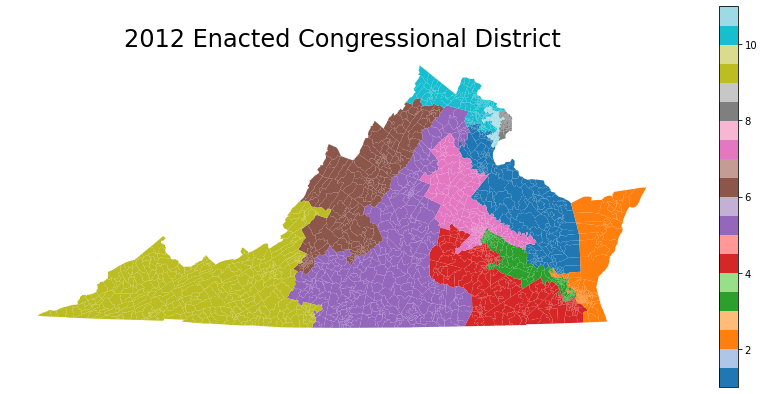

In [9]:
# Plotting districting plan
title = "2012 Enacted Congressional District"
plot_partition(initial_partition, title)

### Compactness score

A district's `Polsby-Popper score` falls with the range of `[0,1]` and a score closer to 1 indicates a more compact district.

In [10]:
# Compute Polsby-Popper compactness scores
# for each district in the partition
compact_scores = gm.polsby_popper(initial_partition)
sorted_compact_scores = sorted(compact_scores.items(), 
                               key=lambda x: x[1], 
                               reverse=True)
for dist, score in sorted_compact_scores:
    print("District: {:<5}".format(int(dist)),
          "Polsby-Popper compactness score: {:.2f}".format(score, 2))

District: 8     Polsby-Popper compactness score: 0.25
District: 2     Polsby-Popper compactness score: 0.20
District: 4     Polsby-Popper compactness score: 0.19
District: 9     Polsby-Popper compactness score: 0.18
District: 1     Polsby-Popper compactness score: 0.17
District: 6     Polsby-Popper compactness score: 0.16
District: 5     Polsby-Popper compactness score: 0.15
District: 7     Polsby-Popper compactness score: 0.13
District: 10    Polsby-Popper compactness score: 0.12
District: 11    Polsby-Popper compactness score: 0.09
District: 3     Polsby-Popper compactness score: 0.08


### Vote

The total number of votes that `party` received.

In [11]:
# 2016 Presidential Election
election_pres16 = 'PRES16'
pres16 = initial_partition[election_pres16]
pres16_rd = initial_partition_rd[election_pres16]

# U.S. parties
parties = pres16.election.parties[:2]

In [12]:
def compute_stats(election, parties, compute, stat):
    """
    Compute statistics in the result of an election.
    """
    for party in parties:
        print("Party: {:15}".format(party),  
              "{}: {:,}".format(stat, compute(party)))

In [13]:
compute_stats(pres16, parties, pres16.count, 'Total number of votes')

Party: Democratic      Total number of votes: 1,978,980
Party: Republican      Total number of votes: 1,768,781


### Wasted votes

Computes the wasted votes for each party in the given race. :party1_votes: the number of votes party1 received in the race :party2_votes: the number of votes party2 received in the race

In [14]:
d, r = \
    gm.wasted_votes(pres16.count('Democratic'), pres16.count('Republican'))
print(f"Democratic: {d:,} Republican: {r:,}")

Democratic: 105,099.5 Republican: 1,768,781


In [15]:
wasted_votes = {"Democratic": [], "Republican": []}
for d, r in zip(pres16.votes('Democratic'), pres16.votes('Republican')):
    wd, wr = gm.wasted_votes(d, r)
    wasted_votes['Democratic'].append(wd)
    wasted_votes['Republican'].append(wr)
wasted_votes.update({'District': range(1,12)})
wasted_votes = pd.DataFrame(wasted_votes)
wasted_votes = wasted_votes.set_index('District')
wasted_votes = wasted_votes.style.format('{:,.0f}')
wasted_votes

,Democratic,Republican
District,,
1,"165,747","15,089"
2,132,"148,818"
3,"89,861","67,811"
4,"164,013","8,634"
5,"153,029","20,908"
6,"120,447","42,786"
7,"173,387","19,296"
8,"97,632","77,091"
9,"86,635","65,521"


### Votes by district

The total votes cast for party in each district of the partition

In [16]:
def compute_stats_by_district(compute, parties, style=True):
    """
    Compute statistics for each district of each party.
    """
    counts = pd.DataFrame({
    'District': range(1, 12),
    'Democratic Total Votes': compute(parties[0]),
    'Republican Total Votes': compute(parties[1])})
    counts = counts.set_index('District')
    if style:
        counts = counts.style.format('{:,}')
    return counts

In [17]:
counts = compute_stats_by_district(pres16.counts, parties)
counts

,Democratic Total Votes,Republican Total Votes
District,,
1,"165,747","195,925"
2,"149,082","148,818"
3,"247,533","67,811"
4,"164,013","181,282"
5,"153,029","194,844"
6,"120,447","206,019"
7,"173,387","211,980"
8,"272,356","77,091"
9,"86,635","217,677"


### Percent

The percentage of the vote that party received.

In [18]:
compute_stats(pres16, parties, pres16.percent, "Percentage of Total Votes")

Party: Democratic      Percentage of Total Votes: 0.5280432770392776
Party: Republican      Percentage of Total Votes: 0.47195672296072244


### Percents by district

The percentage of the vote that party received in each district of the partition.

In [19]:
percentages = pd.DataFrame({
    'District': range(1, 12),
    'Democratic Percentages of Total Votes': pres16.percents(parties[0]),
    'Republican Percentages of Total Votes': pres16.percents(parties[1])})
percentages.iloc[:, 1:] = percentages.iloc[:, 1:].mul(100)
percentages = percentages.set_index('District')
percentages = percentages.style.format('{:.0f}')
percentages

,Democratic Percentages of Total Votes,Republican Percentages of Total Votes
District,,
1,46,54
2,50,50
3,78,22
4,47,53
5,44,56
6,37,63
7,45,55
8,78,22
9,28,72


### Seats

The number of seats won by a party in the election.

In [20]:
compute_stats(pres16, parties, pres16.seats, 'Seats won')

Party: Democratic      Seats won: 5
Party: Republican      Seats won: 6


### Efficiency gap

Computes the efficiency gap for this ElectionResults object. `A positive value` indicates `an advantage` for `the first party` listed in the Election’s parties_to_columns dictionary.

In [21]:
pres16.efficiency_gap()

-0.1086791553676982

In [22]:
pres16_rd.efficiency_gap()

0.1086791553676982

### Mean Median

Computes the Mean-Median score for the given ElectionResults. `A positive value` indicates `an advantage` for `the first party` listed in the Election’s parties_to_columns dictionary.

In [23]:
# Compute the Mean-Median score for the 2016 Presidential election
pres16.mean_median()

-0.05230007534447001

In [24]:
pres16_rd.mean_median()

0.052300075344470065

### Partisan bias

Computes the partisan bias for the given ElectionResults. The partisan bias is defined as the number of districts with above-mean vote share by the first party divided by the total number of districts, minus 1/2.

In [25]:
pres16.partisan_bias()

-0.13636363636363635

In [26]:
pres16_rd.partisan_bias()

0.13636363636363635

### Partisan gini

Computes the partisan Gini score for the given ElectionResults. The partisan Gini score is defined as the area between the seats-votes curve and its reflection about (.5, .5).

In [27]:
pres16.partisan_gini()

0.07364374794026013

In [28]:
pres16_rd.partisan_gini()

0.07364374794026017

<a id='step3'></a>
## Step 3: Setting up the Markov chain

### Proposal

In [ ]:
# The ReCom proposal needs to know the ideal population 
# for the districts so that we can improve speed by 
# bailing early on unbalanced partitions.
ideal_population = \
    sum(initial_partition["population"].values()) / len(initial_partition)
print(ideal_population)

In [ ]:
# Use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.05,
                   node_repeats=2)

### Constraints

In [ ]:
# To keep districts about as compact as the original plan, 
# bound the number of cut edges at 2 times the number of cut edges 
# in the initial plan
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)
pop_constraint = \
    constraints.within_percent_of_ideal_population(initial_partition, 0.05)

### Configuring the Markov chain

In [ ]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[pop_constraint, compactness_bound],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

<a id='step4'></a>
## Step 4:Running the chain

In [ ]:
# Run the chain, putting the sorted Asian voting age population percentages
# into a pandas DataFrame for analysis and plotting.
# This will take about 10 minutes.

asian_vpop = pd.DataFrame(
    sorted(partition["VPOP"].percents("Asian"))
    for partition in chain
)

In [ ]:
asian_vpop.shape

In [ ]:
def plot_dist(df, title, ylab, xlab="Sorted districts", figsize=(10,8)):
    """Plot distribution of each plan for each district."""
    fig, ax = plt.subplots(figsize=figsize)

    # Draw 50% line
    ax.axhline(0.5, color="#cccccc")

    # Draw boxplot
    df.boxplot(ax=ax, positions=range(len(df.columns)))

    # Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
    plt.plot(df.iloc[0], "ro")

    # Annotate
    ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylab, fontsize=18)
    ax.set_xlabel(xlab, fontsize=18)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

    plt.show()

In [ ]:
title = "Comparing the 2012 plan to an ensemble"
ylab = "Asian Voting Age Population (%)"
plot_dist(asian_vpop, title, ylab)

In [ ]:
dem_pres = pd.DataFrame(
    sorted(partition["PRES16"].percents("Democratic"))
    for partition in chain
)

In [ ]:
ylab = "Democratic Vote % (Presential Ele 2016)"
plot_dist(dem_pres, title, ylab)
